<a href="https://colab.research.google.com/github/sophie-myk/AIFFEL_quest_cr/blob/main/Exploration/Quest07/250424_ex07_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

In [3]:
print(keras.__version__)

3.8.0


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
X_train = x_train.reshape(-1,28, 28, 1)  # reshaping for convnet
X_test = x_test.reshape(-1,28,28,1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
print(X_train.shape)

(60000, 28, 28, 1)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)

(48000, 28, 28, 1)


In [8]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [9]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


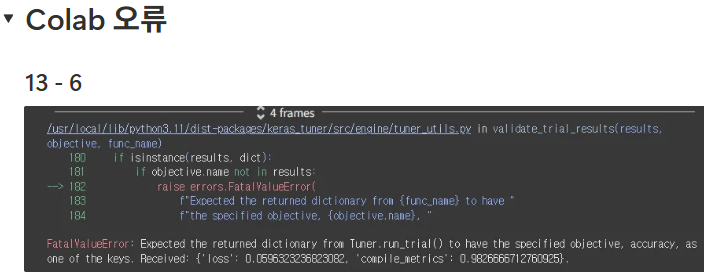
## 코랩에서 돌리면 keras가 최신버전이라서 이런 오류가 납니다.

이상하게 metrics_names을 accuracy로 안 주고 compile_metrics로 줍니다.를 수정

In [10]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        # objective=kt.Objective('accuracy', 'max'),
        #############이부분을 변경!!#######################
			  objective=kt.Objective('compile_metrics', 'max'),
        #############이부분을 변경!!#######################
        max_trials=2,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)


Trial 2 Complete [00h 01m 28s]
compile_metrics: 0.9835000038146973

Best compile_metrics So Far: 0.9835000038146973
Total elapsed time: 00h 02m 41s


In [11]:
!mkdir -p aiffel/mlops/best_model/1

In [12]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 26, 26, 67)          │             670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 24, 24, 77)          │          46,508 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 22, 22, 52)          │          36,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 20, 20, 127)         │          59,563 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 18, 18, 92)          │         105,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 122)         │         101,138 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 14, 14, 37)          │          40,663 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 12, 12, 32)          │          10,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 10, 10, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │         102,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,632 (1.96 MB)

 Trainable params: 513,632 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
save_path = '/content/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
# fname = os.path.join(save_path, 'model.keras')
model.export(fname) ## 이부분을 save대신에 export로 변경

Saved artifact at '/content/aiffel/mlops/best_model/1/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134878817848784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817847632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878761625232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817848592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817847248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817859920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817848016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348984784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348989008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348990544: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)


Saved artifact at '/tmp/tmpjovtnlqk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134878817848784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817847632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878761625232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817848592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817847248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817859920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878817848016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348984784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348989008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348990544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878348989968: Tens

In [17]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [18]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [19]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['output_0']}}


In [20]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

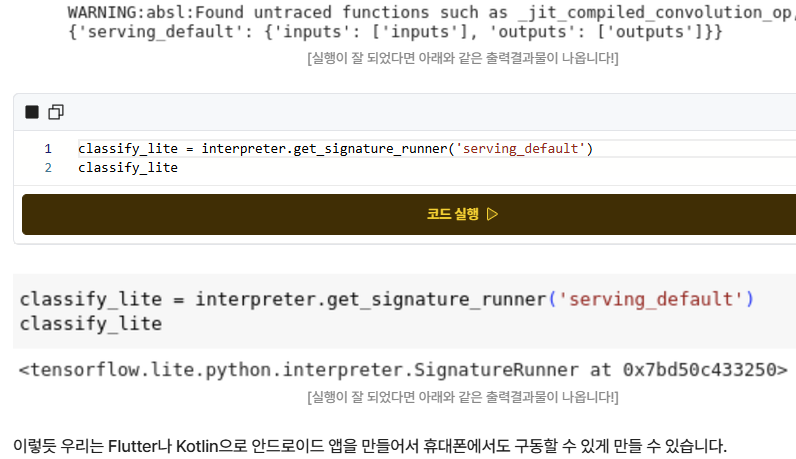